# Assignment 2
## Question 1: Siamese networks & one-shot learning (7pt)
The Cifar-100 dataset is similar to the Cifar-10 dataset. It also consists of 60,000 32x32 RGB images, but they are distributed over 100 classes instead of 10. Thus, each class has much fewer examples, only 500 training images and 100 testing images per class. For more info about the dataset, see https://www.cs.toronto.edu/~kriz/cifar.html.

*HINT: Import the Cifar-100 dataset directly from Keras, no need to download it from the website. Use* `label_mode="fine"`

### Task 1.1: Siamese network
**a)**
* Train a Siamese Network on the first 80 classes of (the training set of) Cifar-100, i.e. let the network predict the probability that two input images are from the same class. Use 1 as a target for pairs of images from the same class (positive pairs), and 0 for pairs of images from different classes (negative pairs). Randomly select image pairs from Cifar-100, but make sure you train on as many positive pairs as negative pairs.

* Evaluate the performance of the network on 20-way one-shot learning tasks. Do this by generating 250 random tasks and obtain the average accuracy for each evaluation round. Use the remaining 20 classes that were not used for training. The model should perform better than random guessing.

For this question you may ignore the test set of Cifar-100; it suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.

*HINT: First sort the data by their labels (see e.g.* `numpy.argsort()`*), then reshape the data to a shape of* `(n_classes, n_examples, width, height, depth)`*, similar to the Omniglot data in Practical 4. It is then easier to split the data by class, and to sample positive and negative images pairs for training the Siamese network.*

*NOTE: do not expect the one-shot accuracy for Cifar-100 to be similar to that accuracy for Omniglot; a lower accuracy can be expected. However, accuracy higher than random guess is certainly achievable.*

In [0]:
from sklearn.utils import shuffle
from keras.models import Model, Sequential, load_model
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, Lambda, Flatten, BatchNormalization, concatenate
from keras.utils import to_categorical
from keras.regularizers import l2
from keras.losses import binary_crossentropy
from keras.initializers import Zeros
from keras.optimizers import Adam, SGD
from keras import backend as K
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
%matplotlib inline

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
path = F"/content/gdrive/My Drive/Colab Notebooks/Assignment_2/" 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
from keras.datasets import cifar100
(x,y), (xx, yy)=cifar100.load_data(label_mode="fine")

169009152/169001437 [==============================] - 13s 0us/step


In [0]:
def normalize(x,y):
    y = y.flatten()
    sort = np.argsort(y)
    y = y[sort]
    x = x[sort]

    x=np.array(x, dtype=np.float64)
    x /= 255
    x = x.reshape(100,-1,32,32,3)
    x_train = x[:80,:,:,:,:]
    y_train = y[:int(x.shape[0]*x.shape[1]*0.8)]
    x_test = x[80:,:,:,:,:]
    y_test = y[int(x.shape[0]*x.shape[1]*0.8):]
    
    y_train = to_categorical(y_train,100)
    y_test = to_categorical(y_test,100)
    return x,y,x_train,y_train,x_test,y_test

In [0]:
"""

The naming is not very understandable. x and y are the training set of Cifar-100, and xx, yy are the test set. 
x_train and y_train are the first 80 classes of the training set, and x_test and y_test are the last 20 classes of the training set.
Likewise, xx_train and yy_train are the first 80 classes of the training set, and xx_test and yy_test are the last 20 classes of the training set.


"""
x,y,x_train,y_train,x_test,y_test = normalize(x,y)
xx_t, yy_t, xx_train, yy_train, xx_test, yy_test = normalize(xx,yy) 

Class label: aquarium_fish


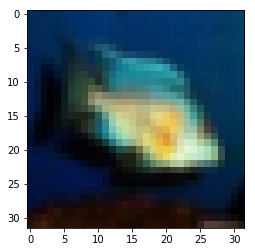

In [0]:
#Visualizing
example_class = np.random.randint(0,79)  # pick any integer from 0 to 80
example_id = np.random.randint(0,499) # pick any integer from 0 to 499
example = x_train[example_class][example_id]
labels = [ 'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 
          'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 
          'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 
          'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 
          'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 
          'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 
          'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 
          'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm', ]
label = y_train[example_class*500+example_id]
print("Class label:", labels[np.argmax(label)])
plt.imshow(example)
plt.show()

In [0]:
train_labels = labels[:80]
test_labels = labels[80:]

In [0]:
def get_batch(batch_size, X):
    """Create batch of n pairs, half same class, half different class"""
    n_classes, n_examples, w, h, r = X.shape 
    # for x_train. n_classes, n_examples, w, h, r = (80, 500, 32, 32, 3)
    
    # randomly sample several classes to use in the batch
    categories = np.random.choice(n_classes, size=(batch_size,))

    # initialize 2 empty arrays for the input image batch
    pairs = [np.zeros((batch_size, h, w, r)) for i in range(2)]
    # initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
    targets = np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    for i in range(batch_size):
        category = categories[i]
        idx_1 = np.random.randint(n_examples)
        pairs[0][i, :, :, :] = X[category, idx_1].reshape(w, h, r)
        idx_2 = np.random.randint(n_examples)
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category
        else:
            #add a random number to the category modulo n_classes to ensure 2nd image has different category
            category_2 = (category + np.random.randint(1,n_classes)) % n_classes
        pairs[1][i, :, :, :] = X[category_2,idx_2].reshape(w, h, r)
    return pairs, targets

def batch_generator(batch_size, X):
    """a generator for batches, so model.fit_generator can be used. """
    while True:
        pairs, targets = get_batch(batch_size, X)
        yield (pairs, targets)

def train_siamese_model(model, x_train, batch_size=64, steps_per_epoch=100, epochs=1):
    model.fit_generator(batch_generator(batch_size, x_train), steps_per_epoch=steps_per_epoch, epochs=epochs,verbose=0)

In [0]:
def make_oneshot_task(N, X, c):
    """Create pairs of (test image, support set image) with ground truth, for testing N-way one-shot learning."""
    n_classes, n_examples, w, h, r = X.shape
    indices = np.random.randint(0, n_examples, size=(N,))
    categories = np.random.choice(range(n_classes), size=(N,), replace=False)            
    true_category = categories[0]
    ex1, ex2 = np.random.choice(n_examples, replace=False, size=(2,))
    test_image = np.asarray([X[true_category, ex1, :, :]]*N).reshape(N, w, h, r)
    support_set = X[categories, indices, :, :]
    support_set[0, :, :] = X[true_category, ex2]
    support_set = support_set.reshape(N, w, h, r)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image, support_set]
    return pairs, targets

def test_oneshot(model, X, c, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N, X, c)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

In [0]:
def get_siamese_model():
    input_shape = (32,32,3)
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(64, (4,4), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    model.add(Conv2D(256, (2,2), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='sigmoid', kernel_regularizer=l2(1e-3)))
    model.summary()

    left_encoded = model(left_input)
    right_encoded = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([left_encoded, right_encoded])

    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid')(L1_distance)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    siamese_net.compile(loss="binary_crossentropy",optimizer=Adam(lr=0.00005))
    return siamese_net

In [0]:
def train_and_test_siamese_model(model=None,best_acc=0,loops=200, evaluate_every=10,save=True):
    if not model:
        model = get_siamese_model()
    total_acc = 0
    for i in range(loops):
        train_siamese_model(model, x_train, batch_size=64, steps_per_epoch=100, epochs=1)
        if i % evaluate_every == 0:
            print("Training loop {} ===".format(i))
            acc = test_oneshot(model, x_test, test_labels, N=20, k=250, verbose=True)
            total_acc += acc
            if acc > best_acc:
                best_acc = acc
                if save:
                    model.save(path+"siamese_net.h5")
    print(f'Total accuracy: {total_acc / loops}')
    print(f'Best accuracy: {best_acc}')
    return model

In [0]:
#siamese_model = get_siamese_model()

siamese_model = load_model(path+"siamese_net.h5")
siamese_model = train_and_test_siamese_model(model=siamese_model,loops=10,evaluate_every=1,best_acc=0.3,save=False)

Training loop 0 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 22.4% accuracy for 20-way one-shot learning
Training loop 1 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 27.6% accuracy for 20-way one-shot learning
Training loop 2 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 22.4% accuracy for 20-way one-shot learning
Training loop 3 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 23.6% accuracy for 20-way one-shot learning
Training loop 4 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 21.6% accuracy for 20-way one-shot learning
Training loop 5 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 21.6% accuracy for 20-way one-shot learning
Training loop 6 ===
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 19.6% ac

***

**b)** Compare the performance of your Siamese network for Cifar-100 to the Siamese network from Practical 4 for Omniglot. Name three fundamental differences between the Cifar-100 and Omniglot datasets. How do these differences influence the difference in one-shot accuracy?

**Answer:**

Clearly the Siamese network performs better, in terms of accuracy, on the Omniglot dataset. With the Cifar-100 dataset, we can get an accuracy of at most 30% for a batch of one-shot tasks, while with Omniglot dataset, we can get an accuracy around 35%, up to 40%.

There are three major differences between the Omniglot and the Cifar-100 datasets which impact the result in performance. 

1.  Omniglot images have 105x105 resolution, while the data in the Cifar-100 dataset are 32x32 images. 
2.  Omniglot images are monochrome, while Cifar-100 images have a depth of 3, corresponding to RGB values.
3.  Omniglot dataset has 50 classes, corresponding to 50 languages/scripts. In Cifar-100 dataset, there are 100 classes of objects. Siamese network for Omniglot case is trained on a subset of 30 scripts, while the network for Cifar-100 is trained on a subset of 80 classes. 

Lower resolution and colored images make classification a harder task. We might notice that we need a higher number of parameters to generate a network for the Omniglot dataset, but a higher number of parameters implies a more refined classification due to the possibility of detecting more features, while in the Cifar dataset the structure introduce much more noise, specially due to the resolution of the images. 

When using Cifar-100 the networks learns how to differentiate between a larger number of classes than Omniglot, therefore the distance metric that is supposed to be learned by the network can be arbitrarily more complicated, which can lead to a lower accuracy. 

***

### Task 1.2: One-shot learning with neural codes
**a)**
* Train a CNN classifier on the first 80 classes of Cifar-100. Make sure it achieves at least 40% classification accuracy on those 80 classes (use the test set to validate this accuracy).
* Then use neural codes from one of the later hidden layers of the CNN with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.

In [0]:
def create_neural_code_model(x_train,y_train,n_classes):
    
    input_shape = (32,32,3)
    model = Sequential()
    model.add(Conv2D(128, (3,3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
    model.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Dropout(0.1))
    model.add(Conv2D(256, (2,2), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(n_classes, activation='softmax'))
    model.summary()
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    batch_size = 64
    epochs = 20
    x_train, y_train = shuffle(x_train,y_train)
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs)
    return model

In [0]:
neural_model = create_neural_code_model(x_train.reshape(40000,32,32,3),y_train,100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 256)       131328    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 9216)              0         
__________

In [0]:
neural_model.evaluate(x=xx_train.reshape(8000,32,32,3), y=yy_train)

8000/8000 [==============================] - 1s 175us/step


[2.489718846201897, 0.454]

In [0]:
def test_oneshot_with_code(model, X, c, N=20, k=250, verbose=True):
    """Test average N-way oneshot learning accuracy of a siamese neural net over k one-shot tasks."""
    n_correct = 0
    if verbose:
        print("Evaluating model on {} random {}-way one-shot learning tasks ...".format(k, N))
    for i in range(k):
        inputs, targets = make_oneshot_task(20, X, test_labels)
        probs_1 = model.predict(inputs[0])
        probs_2 = model.predict(inputs[1])
        distances = [np.linalg.norm(x-y) for x,y in zip(probs_1,probs_2)]
        if np.argmin(distances) == np.argmax(targets):
            n_correct += 1
    percent_correct = (100.0*n_correct / k)
    if verbose:
        print("Got an average of {}% accuracy for {}-way one-shot learning".format(percent_correct, N))
    return percent_correct

In [0]:
neural_code_intermediate_model = Model(inputs=neural_model.input, outputs=neural_model.layers[-2].output)
loops = 20
acc = 0.0
max_acc = 0.0
for i in range(loops):
    curr_acc = test_oneshot_with_code(neural_code_intermediate_model, x_test, test_labels)
    if curr_acc > max_acc:
        max_acc = curr_acc
    acc += curr_acc
print("Average accuracy: {}".format(acc / loops))
print("Maximum accuracy: {}".format(max_acc))

Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 11.6% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.4% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 16.0% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.0% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.2% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 16.8% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 15.2% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 13.2% accuracy for 2

***

**b)** Briefly motivate your CNN architecture, and discuss the difference in one-shot accuracy between the Siamese network approach and the CNN neural codes approach.

**Answer:**

Our CNN architecture comes from both Internet search for best practices and from trial/error. Since we are getting a lower accuracy on our validation set, we tried to introduce regularization, dropout, and maxpooling layers to prevent overfitting. We are able to get ~45% accuracy on the test data for the first 80 classes. 


The difference in accuracy is very small for the Siamese network approach and CNN neural codes approach. This stems from the similarity of the approaches - both approaches are working on a single CNN that is used to achieve neural codes. The difference is, with the Siamese approach, the network also includes an L1 distance layer between the two twin networks, and backpropagation relies on the loss computed based on the result of this distance. 

***
## Question 2: Triplet networks & one-shot learning (10pt)

### Task 2.1: Train a triplet network
**a)**
* Train a triplet network on the first 80 classes of (the training set of) Cifar-100.
 
* Make sure the network achieves a smaller loss than the margin and the network does not collapse all representations to zero vectors. *HINT: If you experience problems to achieve this goal, it might be helpful to tinker the learning rate.*

* You are provided with a working example of triplet loss implementation for Keras below. You may directly use it.

You may ignore the test set of Cifar-100 for this question as well. It suffices to use only the training set and split this, using the first 80 classes for training and the remaining 20 classes for one-shot testing.



In [0]:
# Notice that ground truth variable is not used for loss calculation. It is used as a function argument to by-pass some Keras functionality. 
# This is because the network structure already implies the ground truth for the anchor image with the "positive" image.
import tensorflow as tf
def triplet_loss(ground_truth, network_output):

    anchor, positive, negative = tf.split(network_output, num_or_size_splits=3, axis=1)        

    for embedding in [anchor, positive, negative]:
        embedding = tf.math.l2_normalize(embedding)

    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, positive)), axis=1)
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor, negative)), axis=1)

    margin = 0.2 # define your margin
    basic_loss = tf.add(tf.subtract(pos_dist, neg_dist), margin)
    loss = tf.reduce_mean(tf.maximum(basic_loss, 0.0), axis=0)

    return loss

In [0]:
def get_triplet_model():
    input_shape = (32,32,3)
    positive_input = Input(input_shape)
    anchor_input = Input(input_shape)
    negative_input = Input(input_shape)

    model = Sequential()
    model.add(Conv2D(32, (5,5), activation='relu', input_shape=input_shape,kernel_initializer='random_normal',))
    model.add(BatchNormalization())
    model.add(MaxPooling2D())
    model.add(Conv2D(64, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (3,3), activation='relu'))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (2,2), activation='relu'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.summary()

    positive_encoded = model(positive_input)
    anchor_encoded = model(anchor_input)
    negative_encoded = model(negative_input)
    
    # Connect the inputs with the outputs
    concatvector = concatenate([anchor_encoded, positive_encoded, negative_encoded], axis=-1, name='merged_layer')
    triplet_net = Model(inputs=[anchor_input,positive_input,negative_input],outputs=concatvector)
    triplet_net.compile(loss=triplet_loss,optimizer=Adam(lr=0.0001)) 
    return triplet_net

In [0]:
import random
def get_triplet_batch(x,batch_size=128):
    """anchor_data = []
    positive_data = []
    negative_data = []
    for i in range(80):
        one_class = shuffle(x[i])
        anchor_data.append(one_class[:250,:,:,:])
        positive_data.append(one_class[250:,:,:,:])
        rand_ind = np.random.randint(0,249)
        const_neg_data = []
        for j in range(250):
            other_class = random.choice([a for a in range(0,80) if a != i])
            const_neg_data.append(x[other_class,np.random.randint(0,499),:,:,:])
        negative_data.append(const_neg_data)
    anchor_data = np.asarray(anchor_data).reshape(-1,32,32,3)
    positive_data = np.asarray(positive_data).reshape(-1,32,32,3)
    negative_data = np.asarray(negative_data).reshape(-1,32,32,3)"""
    
    anchor_data = []
    positive_data = []
    negative_data = []
    for j in range(batch_size):
        i = np.random.randint(0,79)
        anchor_data.append(x[i,np.random.randint(0,499),:,:,:])
        positive_data.append(x[i,np.random.randint(0,499),:,:,:])
        other_class = random.choice([a for a in range(0,80) if a != i])
        negative_data.append(x[other_class,np.random.randint(0,499),:,:,:])
    #print(len(anchor_data[0]))
    anchor_data = np.asarray(anchor_data).reshape(-1,32,32,3)
    positive_data = np.asarray(positive_data).reshape(-1,32,32,3)
    negative_data = np.asarray(negative_data).reshape(-1,32,32,3)
    
    y_dummy = np.empty(batch_size)
    
    return [anchor_data,positive_data,negative_data], y_dummy
    
def triplet_batch_generator(batch_size, x):
    while True:
        pairs, targets = get_triplet_batch(x,batch_size)
        yield (pairs, targets)

def train_triplet_model_batch(model, x_train, batch_size=64, steps_per_epoch=100, epochs=1):
    model.fit_generator(triplet_batch_generator(batch_size, x_train), steps_per_epoch=steps_per_epoch, epochs=epochs,verbose=0)

In [0]:
def train_triplet_model(model=None,best_acc=0,loops=200, evaluate_every=10):
    if not model:
        model = get_triplet_model()
    for i in range(loops):
        print("Training loop : {}".format(i))
        train_triplet_model_batch(model, x_train, batch_size=64, steps_per_epoch=100, epochs=1)
    return model

In [0]:
import keras.losses
keras.losses.triplet_loss = triplet_loss
triplet_model = load_model(path+"triplet_model.h5") #loading the module from drive, to avoid repeated training

In [0]:
#triplet_model=train_triplet_model(model=triplet_model,loops=10,evaluate_every=1)
#triplet_model.save(path+"triplet_model.h5")

***

### Task 2.2: One-shot learning with triplet neural codes
**a)**
* Use neural codes from the triplet network with L2-distance to evaluate one-shot learning accuracy for the remaining 20 classes of Cifar-100 with 250 random tasks. I.e. for a given one-shot task, obtain neural codes for the test image as well as the support set. Then pick the image from the support set that is closest (in L2-distance) to the test image as your one-shot prediction.
* Explicitly state the accuracy.

In [0]:
triplet_network_intermediate_model = Sequential()
for layer in triplet_model.layers[3].layers:
    triplet_network_intermediate_model.add(layer)

In [0]:
loops = 10
acc = 0.0
max_acc = 0.0
for i in range(loops):
    curr_acc = test_oneshot_with_code(triplet_network_intermediate_model, x_test, test_labels)
    if curr_acc > max_acc:
        max_acc = curr_acc
    acc += curr_acc
print("Average accuracy: {}".format(acc / loops))
print("Maximum accuracy: {}".format(max_acc))

Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 19.2% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 20.0% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 20.0% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 14.8% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 19.6% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 18.8% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 22.8% accuracy for 20-way one-shot learning
Evaluating model on 250 random 20-way one-shot learning tasks ...
Got an average of 17.2% accuracy for 2

***
## Question 3: Performance comparison (3pt)


**a)** What accuracy would random guessing achieve (on average) on this dataset? Motivate your answer briefly.

Random guessing would achieve 5% accuracy. There are 20 classes into which the images can be classified. A random guess, on average, would be correct 1 out of 20 times, hence 5%. 


**b)** Discuss and compare the performances of networks in tasks 1.1, 1.2 and 2.2. Briefly motivate and explain which task would be expected the highest accuracy. Explain the reasons of the accuracy difference if there are any. If there is almost no difference accuracy, explain the reason for that.

In theory, neural codes that we get after training the triplet network should have the highest accuracy. This follows from the triplet loss: the network learns in a way to maximize the distance between two images when they do not belong to the same class, while trying to minimize the distance between two images when they indeed belong to the same class. On the other hand, the Siamese network tries to optimize to find whether two images are of the same class - the loss is binary cross-entropy. This subtle difference makes triplet network more powerful, as the authors of papers that have used triplet networks show. 

However, in our implementations and experiments, we observe quite similar results for the methods in 1.1 and 2.2. In fact, Siamese network and neural codes from Triplet network give similar accuracies, around the band of 25%, whereas neural codes from Siamese network gives an accuracy around the band of 20%. The difference is not very extreme, and we believe the difference is the repeated batch training that we apply on Siamese network and Triplet network, allowing for better fitting the data. 

***
## Question 4: Peer review (0pt)

Finally, each group member must write a single paragraph outlining their opinion on the work distribution within the group. Did every group member contribute equally? Did you split up tasks in a fair manner, or jointly worked through the exercises. Do you think that some members of your group deserve a different grade from others?

Andrea Bonfanti: We all shared the work equally.

Berk Isler: We all shared the work equally.

Gokhan Simsek: We all shared the work equally.